# Image and Keypoints Augmentations using Kornia and Ivy's Transpiler

## Introduction

This tutorial is adapted from [Kornia's official tutorial](https://kornia.github.io/tutorials/nbs/image_points_transforms.html). We demonstrate how to utilize `kornia.augmentation.AugmentationSequential` to apply augmentations to images and transform associated keypoints, leveraging Ivy's Transpiler to run these augmentations in JAX using `ivy.transpile`. 

### Original Tutorial Credits
The original tutorial and code are courtesy of [Kornia](https://kornia.github.io/). This notebook serves as an adapted version, showcasing the integration with Ivy's Transpiler for JAX compatibility.


<a href="https://colab.sandbox.google.com/github/kornia/tutorials/blob/master/nbs/image_points_transforms.ipynb"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open in google colab"></a>

## Installation and Setup

In [ ]:
%%capture
!pip install kornia
!pip install kornia-rs matplotlib
!pip install -q ivy 

!rm -rf ivy_transpiled_outputs/

In [ ]:
import kornia as K
import torch
from matplotlib import pyplot as plt
import ivy 
import jax.numpy as jnp

In [1]:
import io

import requests


def download_image(url: str, filename: str = "") -> str:
    filename = url.split("/")[-1] if len(filename) == 0 else filename
    # Download
    bytesio = io.BytesIO(requests.get(url).content)
    # Save file
    with open(filename, "wb") as outfile:
        outfile.write(bytesio.getbuffer())

    return filename


download_image("https://github.com/kornia/data/raw/main/arturito.jpg")

'arturito.jpg'

 This line lazily transpiles everything in the kornia api to `JAX`, and creates a new module for this transpiled version of kornia.
Because the transpilation happens lazily, no function or class will be transpiled until it's actually called.

In [3]:
transpiled_kornia = ivy.transpile(K, source='torch', target='jax')

Calling `transpiled_kornia.io.load_image` will now trigger a transpilation. If this is the 1st time you are transpiling, it will take a few minutes. All subsequent transpilation will reuse the transpiled version and will be much faster.

In [4]:
img = transpiled_kornia.io.load_image("arturito.jpg", transpiled_kornia.io.ImageLoadType.RGB32)
img = img[None]  # 1xCxHxW / fp32 / [0, 1]
print(img.shape)

(1, 3, 144, 256)


## Draw points and show image

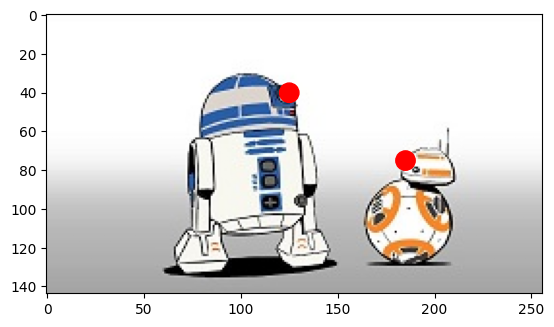

In [5]:
coords = jnp.asarray([[[125, 40.0], [185.0, 75.0]]])  # BxNx2 [x,y]

fig, ax = plt.subplots()

ax.add_patch(plt.Circle((coords[0, 0, 0], coords[0, 0, 1]), color="r"))
ax.add_patch(plt.Circle((coords[0, 1, 0], coords[0, 1, 1]), color="r"))

ax.imshow(transpiled_kornia.tensor_to_image(img))

## Resize points and show

**NOTE:** This cell will lazily transpile `kornia.augmentation.Resize` and `kornia.augmentation.AugmentationSequential`, which can be computationally intensive and can take a few minutes. Time for a snack break! Grab a refreshment and come back to a freshly compiled augmentation sequence.

None


/ivy/tracer-transpiler/ivy_transpiled_outputs/jax_outputs/ivy/functional/backends/jax/creation.py:89: UserWarning: Explicitly requested dtype <class 'jax.numpy.int64'> requested in asarray is not available, and will be truncated to dtype int32. To enable more dtypes, set the jax_enable_x64 configuration option or the JAX_ENABLE_X64 shell environment variable. See https://github.com/jax-ml/jax#current-gotchas for more.
  ret = jax.numpy.asarray(obj, dtype=dtype)
/ivy/tracer-transpiler/ivy_transpiled_outputs/jax_outputs/ivy/functional/backends/jax/data_type.py:156: UserWarning: Explicitly requested dtype <class 'jax.numpy.int64'> requested in astype is not available, and will be truncated to dtype int32. To enable more dtypes, set the jax_enable_x64 configuration option or the JAX_ENABLE_X64 shell environment variable. See https://github.com/jax-ml/jax#current-gotchas for more.
  return jax.numpy.astype(x, dtype)
/ivy/tracer-transpiler/ivy_transpiled_outputs/jax_outputs/ivy/functional/ba

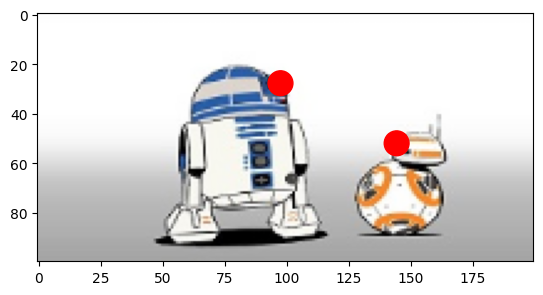

In [6]:
resize_op = transpiled_kornia.augmentation.AugmentationSequential(
    transpiled_kornia.augmentation.Resize((100, 200), antialias=True), data_keys=["input", "keypoints"]
)

print(resize_op.transform_matrix)

img_resize, coords_resize = resize_op(img, coords)


fig, ax = plt.subplots()

ax.add_patch(plt.Circle((coords_resize[0, 0, 0], coords_resize[0, 0, 1]), color="r"))
ax.add_patch(plt.Circle((coords_resize[0, 1, 0], coords_resize[0, 1, 1]), color="r"))

ax.imshow(transpiled_kornia.tensor_to_image(img_resize))

## Crop image and points

Now let us define a center crop augmentation sequence to resize the image to a smaller size.

**NOTE:** This cell will trigger the transpilation of `kornia.augmentation.CenterCrop`. However, since many dependent objects were already transpiled in previous steps (e.g.   `AugmentationSequential`), the transpilation process should be faster due to caching and reuse of existing transpiled artifacts.

None


/ivy/tracer-transpiler/ivy_transpiled_outputs/jax_outputs/ivy/functional/backends/jax/creation.py:89: UserWarning: Explicitly requested dtype <class 'jax.numpy.int64'> requested in asarray is not available, and will be truncated to dtype int32. To enable more dtypes, set the jax_enable_x64 configuration option or the JAX_ENABLE_X64 shell environment variable. See https://github.com/jax-ml/jax#current-gotchas for more.
  ret = jax.numpy.asarray(obj, dtype=dtype)


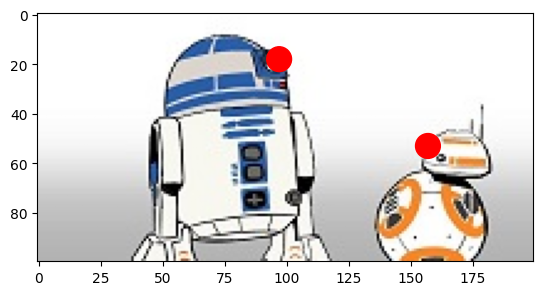

In [7]:
crop_op = transpiled_kornia.augmentation.AugmentationSequential(transpiled_kornia.augmentation.CenterCrop((100, 200)), data_keys=["input", "keypoints"])
print(crop_op.transform_matrix)

img_resize, coords_resize = crop_op(img, coords)


fig, ax = plt.subplots()

ax.add_patch(plt.Circle((coords_resize[0, 0, 0], coords_resize[0, 0, 1]), color="r"))
ax.add_patch(plt.Circle((coords_resize[0, 1, 0], coords_resize[0, 1, 1]), color="r"))

ax.imshow(transpiled_kornia.tensor_to_image(img_resize))

## Conclusion

In this tutorial, we demonstrated how to leverage Ivy's Transpiler to run Kornia's image and keypoints augmentations in JAX. We showcased the application of various augmentations, including resizing and center cropping.

### What's Next?
Want to explore more? Dive into our [documentation](https://www.docs.ivy.dev/) for in-depth guides, tutorials, and API references. Your feedback is invaluable – join our [Discord](https://discord.com/invite/vKqazsCK2Y) to share your thoughts and suggestions.